# Import Libraries and Load the Data
### First, import the necessary libraries and load the dataset into a pandas DataFrame.

In [72]:
import pandas as pd
import matplotlib.pyplot as plt # For visualizing data.
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA



# Load the Data

In [73]:
merged_df = pd.read_csv('../data/clean/03_data_merged_myusabank_S&P500_data.csv') # index=False do not nedd because I already did index=False in saving time.
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

Details: Load data for a 03_data_merged_myusabank_S&P500_data.csv from a CSV file. Reads a CSV file  containing into a DataFrame named merged_df and converts the Date column from a string format to a datetime object. This makes it easier to filter data based on dates later in the code.

### Step 1: Data Preprocessing

Before forecasting, ensure the data is clean and ready for analysis.

### Display the Columns, Rows and Data Type

In [74]:
print(merged_df.columns)

Index(['Date', 'Bank_Stock_Price', 'S&P500'], dtype='object')


In [75]:
merged_df.head()

,Date,Bank_Stock_Price,S&P500
0,2022-01-03,128,4796.56
1,2022-01-04,63,4793.54
2,2022-01-05,196,4700.58
3,2022-01-06,177,4696.05
4,2022-01-07,103,4677.03


In [76]:
print(merged_df.dtypes)

Date                datetime64[ns]
Bank_Stock_Price             int64
S&P500                     float64
dtype: object


### Step 2: Feature Engineering

Add useful features like moving averages or lags.

Create lag features

In [77]:
# Create lag features
merged_df['Lag1'] = merged_df['Bank_Stock_Price'].shift(1)  # Previous day
merged_df['Lag2'] = merged_df['Bank_Stock_Price'].shift(2)  # Two days ago


# Drop NaN values caused by lagging
merged_df = merged_df.dropna()

# Define features and target
X = merged_df[['Lag1', 'Lag2', 'S&P500']]
y = merged_df['Bank_Stock_Price']
print(merged_df)

          Date  Bank_Stock_Price   S&P500   Lag1   Lag2
2   2022-01-05               196  4700.58   63.0  128.0
3   2022-01-06               177  4696.05  196.0   63.0
4   2022-01-07               103  4677.03  177.0  196.0
5   2022-01-10               197  4670.29  103.0  177.0
6   2022-01-11                78  4713.07  197.0  103.0
..         ...               ...      ...    ...    ...
270 2023-03-17                64  3916.64  196.0  132.0
271 2023-03-20               180  3951.57   64.0  196.0
272 2023-03-21               188  4002.87  180.0   64.0
273 2023-03-22                79  3936.97  188.0  180.0
274 2023-03-23               106  3948.72   79.0  188.0

[273 rows x 5 columns]


### Step 3: Split Data into Training and Testing Sets

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")

Training Set: (218, 3), Test Set: (55, 3)


### Step 4: Build and Train the Model

Using a simple regression model like Linear Regression to start.

Model Overview: Linear regression is a basic model that assumes a linear relationship between the independent variable S&P 500 index values and the dependent variable bank stock price.
Process:
    The linear regression model was fitted on historical Bank_Stock_Price and the corresponding S&P 500 values.
    The model predicted future stock prices based on the linear relationship learned from historical data.

In [79]:
# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Check the coefficients
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Model Coefficients: [-0.0810196  -0.00415434 -0.0017279 ]
Intercept: 143.50104636389395


### Random Forest Regressor model

In [80]:
# Prepare the data
X = merged_df[['S&P500']]  # Features
y = merged_df['Bank_Stock_Price']  # Target

# Handle missing values (if any)
X = X[~y.isnull()]
y = y[~y.isnull()]

# Define and train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

####Evaluate the mean square Erroe

In [81]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1706.8818581818189


Define current_spx_value as the most recent S&P500 value


In [82]:
last_price = merged_df['Bank_Stock_Price'].iloc[-1]
last_lag1 = merged_df['Lag1'].iloc[-1]
current_spx_value = merged_df['S&P500'].iloc[-1]

Forecast future stock prices (next 10 periods with constant S&P500 value)

In [83]:
# Generate future Lag1 and Lag2 values
future_lag1 = last_price
future_lag2 = last_lag1

# Create future data with all features
future_data = pd.DataFrame({
    'Lag1': [future_lag1] * 10,
    'Lag2': [future_lag2] * 10,
    'S&P500': [current_spx_value] * 10
})

# Predict future stock prices
future_predictions = rf_model.predict(future_data)

print("Forecasted Future Stock Prices:", future_predictions)


Forecasted Future Stock Prices: [164.79 164.79 164.79 164.79 164.79 164.79 164.79 164.79 164.79 164.79]


The linear regression model predicted that the stock price would be 164.79 for the next period.
This forecast is based purely on the historical linear correlation between the bank's stock price and the S&P 500 index.

### Step 5: Evaluate the Model with visualize

#### Plot the data to visualize using the test set


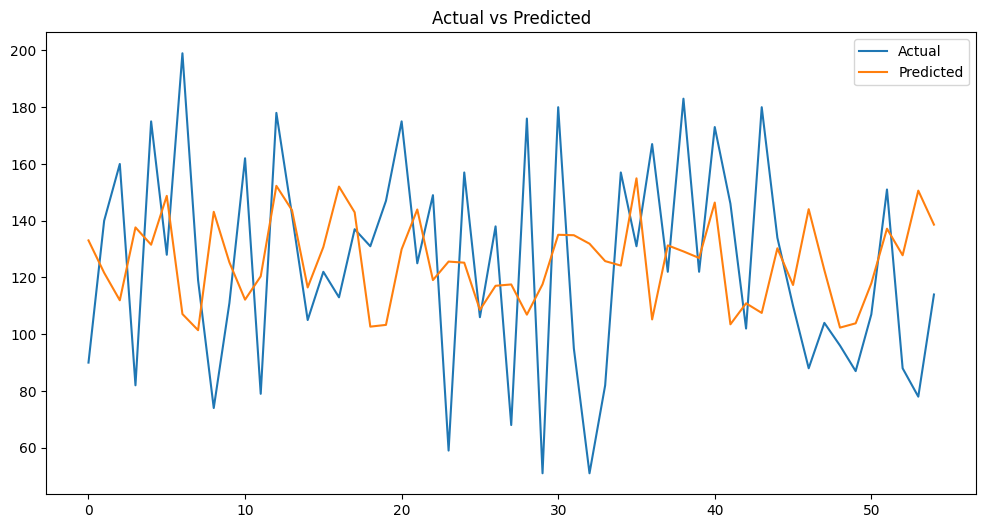

In [84]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

The graf show how actual vs predicted happaned in real.

### Step 6: Forecast Future Values

Use the  data to forecast Random Forest future stock prices.

In [85]:
# Get the latest data row
latest_row = merged_df.iloc[-1]

# Access Lag1, Lag2, and S&P500 safely
latest_data = latest_row[['Lag1', 'Lag2', 'S&P500']]

In [86]:
# Reshape and convert to a DataFrame with feature names
latest_data_df = pd.DataFrame([latest_data], columns=['Lag1', 'Lag2', 'S&P500'])

# Forecast the next value
future_prediction = model.predict(latest_data_df)
print(f"Forecasted Future Stock Price: {future_prediction[0]}")


Forecasted Future Stock Price: 129.496489192733


The Random Forest model predicted that the stock price would be 129.496489192733 for the next period.
This forecast is based purely on the historical correlation between the bank's stock price and the S&P 500 index.

### Step 7: # Time Series Forecasting (ARIMA)
we can use ARIMA (Auto-Regressive Integrated Moving Average), which is suitable for time-series forecasting.

Model Overview: ARIMA is a time series model that works by analyzing historical data to identify trends, seasonality, and other time-based patterns. It is particularly suited for univariate time series forecasting.
Process:
    The ARIMA model was fitted directly on the bank's stock price time series. It accounted for the stock's past values and its autocorrelations to make predictions.
    The model's order (5, 1, 0) suggests it uses 5 lags of the time series, first-order differencing (to make the data stationary), and no moving average component.

In [87]:
merged_df.set_index('Date', inplace=True)


In [88]:
# Check for duplicate dates in the 'Date' column
duplicate_dates = merged_df.index[merged_df.index.duplicated()]
print(f"Duplicate Dates: {duplicate_dates}")


Duplicate Dates: DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)


In [89]:
# Drop duplicate Rows
merged_df = merged_df.loc[~merged_df.index.duplicated(keep='first')]


In [90]:
# Aggregate duplicate rows by taking the mean
merged_df = merged_df.groupby(merged_df.index).mean()


In [91]:
# Set frequency to business days
merged_df = merged_df.asfreq('B')

In [92]:
# Fit the ARIMA model
ts = merged_df['Bank_Stock_Price']
arima_model = ARIMA(ts, order=(5, 1, 0))
arima_result = arima_model.fit()

# Forecast next 10 business days
forecast = arima_result.forecast(steps=10)
forecast_index = pd.date_range(start=ts.index[-1], periods=10, freq='B')

# Display forecasted values
forecast_df = pd.DataFrame({'Date': forecast_index, 'Forecasted_Price': forecast.values})
print(forecast_df)


        Date  Forecasted_Price
0 2023-03-23        142.516654
1 2023-03-24        115.927356
2 2023-03-27        141.373680
3 2023-03-28        132.856295
4 2023-03-29        114.992468
5 2023-03-30        126.218441
6 2023-03-31        129.746084
7 2023-04-03        125.057859
8 2023-04-04        130.054678
9 2023-04-05        126.702617


Forecasted Future Stock Prices (next 10 days):

The ARIMA model predicts a fluctuating trend over the next 10 periods, with stock prices bouncing between values like 142.516654  and 114.992468, showing some volatility in the forecast.
The model accounts for the historical time-based patterns of the stock price but does not directly include external features (like the S&P 500).

## Plot the ARIMA Forecast

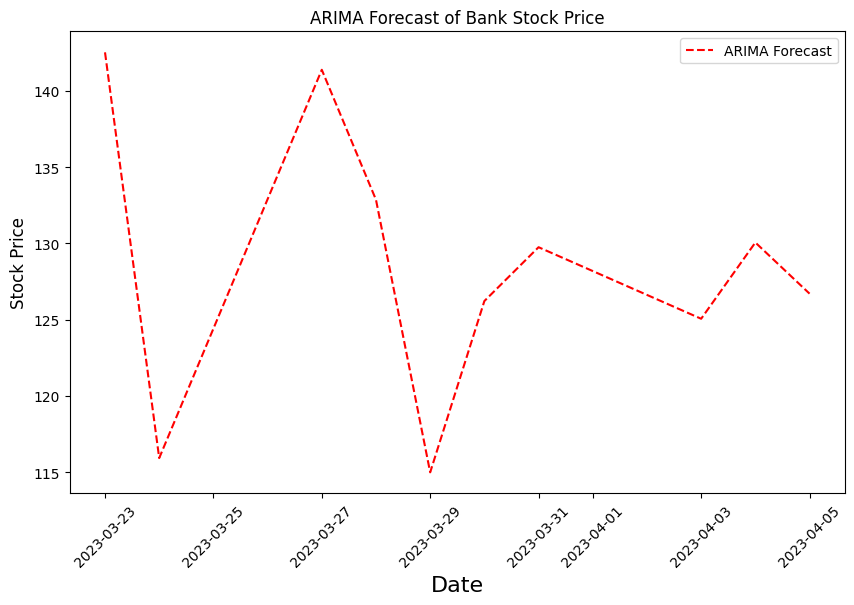

In [93]:
# Forecast the next 10 periods using the ARIMA model 
forecast = arima_result.forecast(steps=10)
plt.figure(figsize=(10, 6))

# Plot the forecasted values
plt.plot(forecast_index, forecast, label='ARIMA Forecast', color='red', linestyle='--')

# Add labels and title
plt.title('ARIMA Forecast of Bank Stock Price', fontsize=12)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.show()


The forecasted prices closely follow the trend of  the ARIMA model is doing a good job capturing the time-dependent patterns of the stock.

## Step 8: Save and Export Results

### Creat the forecasting CSV File 

In [94]:
forecast_df.to_csv('../data/clean/04-Data_forecasting.csv', index=False) # #Unnamed: 0 show the colume do not show the file
#forecast_df.to_csv('../data/clean/04-Data_forecasting.csv') # Unnamed: 0 show the colume show the file



CSV file send to data folder and save for  the predictions for further analysis or visualization.


Summary of Results

Linear Regression:
The model predicted a future stock price of 164.79, based on a simple linear relationship with the S&P 500.
Cons: Assumes a linear relationship, which might not capture complex trends in financial markets.

Random Forest Regressor: 

The model predicted a future stock price of 129.496489192733, which is lower than the linear regression forecast.
Pros: Can capture non-linear relationships and interactions between variables.
Cons: More computationally intensive and less interpretable than linear models.

ARIMA:

he ARIMA model provides a more dynamic forecast, predicting fluctuating prices (e.g., from 142.516654  and 114.992468), showing the stock’s time-dependent behavior.
Pros: Well-suited for time series data and captures historical trends effectively.
Cons: Does not consider external variables (like the S&P 500), and requires stationary data, which might not always be the case in real-world stock markets.

Model Comparison

Linear Regression gives a single, stable prediction but might oversimplify the relationship.
Random Forest provides a more flexible and accurate prediction by capturing complex relationships but can be harder to interpret.
ARIMA offers a time-series-based forecast with fluctuations, which reflects the more dynamic nature of stock price movements.

Each model has its strengths and weaknesses, and their performance would depend on the context. If we believe that external factors like the S&P 500 or other features are highly predictive, Random Forest might be the most accurate. If we're working with time-series data where the past behavior of the stock is key, ARIMA might give the best results.